# Figure 1: Classification Demonstration

This notebook will reproduce Figure 1 from *Heuristic Methods for Determining the Number of Classes in Unsupervised Classification of Climate Models*, E. Boland et al. 2022 (doi to follow). This requires cluster_utils.py and input datafiles via the googleapi CMIP6 store (see cluster_utils.py for more info).

Please attribute any plots or code from this notebook using the DOI from Zenodo: to come

Updated Nov 2022
E Atkinson & E Boland [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39733")
client

<Client: 'tcp://127.0.0.1:39733' processes=6 threads=6, memory=48.00 GiB>

In [10]:
client.shutdown()

2023-04-18 08:46:49,989 - tornado.application - ERROR - Exception in callback <bound method Client._heartbeat of <Client: 'tcp://127.0.0.1:42529' processes=6 threads=6, memory=48.00 GiB>>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 1339, in _heartbeat
    self.scheduler_comm.send({"op": "heartbeat-client"})
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/batched.py", line 140, in send
    raise CommClosedError(f"Comm {self.comm!r} already closed.")
distributed.comm.core.CommClosedError: Comm <TCP (closed) Client->Scheduler local=tcp://127.0.0.1:58914 remote=tcp://127.0.0.1:42529> already closed.
2023-04-18 08:46:54,989 - tornado.application - ERROR - Exception in callback <bound method Client._heartbeat of <Client: 'tcp://127.0.0.1:42529' processes=6 threads

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.cm import get_cmap

import cluster_utils as clu

def get_abt(cov):
  # For finding ellipse parameters from covariance
    w, V = np.linalg.eig(cov)
    t = np.arctan2(V[..., 0, 1], V[..., 0, 0]) * (180 / np.pi)
    return (w[..., 0], w[..., 1], t)

### Step 1: Retrieve the profiles from the CMIP6 googleapi store

In [3]:
data = clu.retrieve_profiles(timeRange = slice('2000-01', '2000-12'),levSel=slice(5, 2000))
data
# Uncomment to save profile meta-data
#np.save('data/levs', data['lev'])
#np.save('data/lons',data['lon'])
#np.save('data/lats',data['lat'])

<xarray.DataArray 'thetao' (time: 12, lev: 50, n: 22194)>
dask.array<getitem, shape=(12, 50, 22194), dtype=float32, chunksize=(8, 50, 22194), chunktype=numpy.ndarray>
Coordinates:
    lat      (n) float32 dask.array<chunksize=(22194,), meta=np.ndarray>
  * lev      (lev) float64 5.14 6.543 8.093 ... 1.653e+03 1.796e+03 1.945e+03
    lon      (n) float32 dask.array<chunksize=(22194,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2000-12-01
  * n        (n) MultiIndex
  - i        (n) int64 0 0 0 0 0 0 0 0 0 ... 359 359 359 359 359 359 359 359 359
  - j        (n) int64 81 82 83 84 85 86 87 88 ... 132 133 134 135 136 137 138
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        mo: This variable is reported using a z* coordinate syste...
    long_name:      Sea Water Potential Temperature
    original_name:  mo: (variable_name: thetao)
    standard_name:  sea_water_potential_temperature
    units:          degC

### Step 2: Create a random sample of profiles, normalise them

In [4]:
data_sampled = clu.random_sample(data, 100).persist() #Takes 100 random Southern Ocean points per month
(data_normalised, data_mean, data_std) = clu.normalise_data(data_sampled, 'N', return_inv=True)

### Step 3: Train a PCA model on the profiles, then transform the profiles to PCA space

In [14]:
n_components = 2
pca = clu.train_pca(data_normalised, n_components)
data_pca = clu.pca_transform(data_normalised, pca)
data = data.chunk({'time': data.sizes['time'], 'n': 1024})
data_full_normalised = clu.normalise_data(data, ('n','time'))
data_full_pca=clu.pca_transform(data_full_normalised, pca)

### Step 4: Train a Gaussian mixture model on the transformed data

In [15]:
n_classes = 3
gmm = clu.train_gmm(data_pca, n_classes)
data_classes = clu.pca_sort(clu.gmm_classify(data_full_pca, gmm), gmm)

In [6]:
n_classes = 4
gmm_4 = clu.train_gmm(data_pca, n_classes)
data_classes_4 = clu.pca_sort(clu.gmm_classify(data_pca, gmm_4), gmm_4)

### Create a plot showing each stage

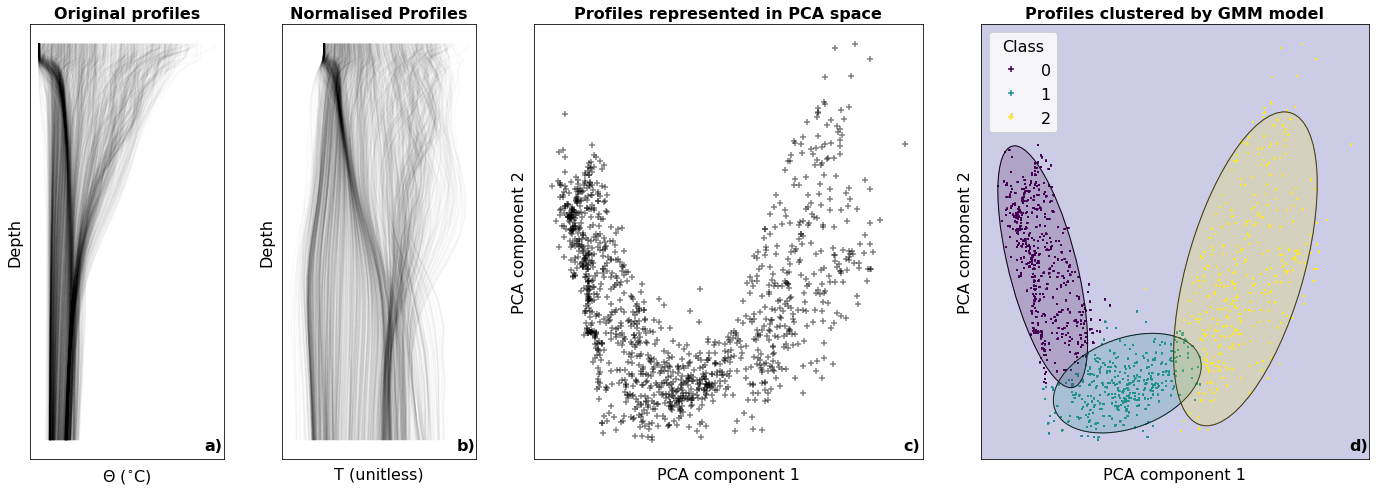

In [6]:
fig, axes = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1,1, 2, 2]})

# Plot the original profiles
axes[0].plot(data_sampled.transpose(), -data_sampled['lev'], c=(0, 0, 0, 0.02))
axes[0].text(0.9,0.02,'a)',transform=axes[0].transAxes,fontsize=16,fontweight='bold')
axes[0].set_xlabel('$\Theta$ ($^{\circ}$C)',fontsize=16)
axes[0].set_ylabel('Depth',fontsize=16)
axes[0].set_title('Original profiles',fontsize=16,fontweight='bold')

# Plot the normalised profiles
axes[1].plot(data_normalised.transpose(), -data_sampled['lev'], c=(0, 0, 0, 0.02))
axes[1].text(0.9,0.02,'b)',transform=axes[1].transAxes,fontsize=16,fontweight='bold')
axes[1].set_xlabel('T (unitless)',fontsize=16)
axes[1].set_ylabel('Depth',fontsize=16)
axes[1].set_title('Normalised Profiles',fontsize=16,fontweight='bold')

# Plot the profiles in PCA space
axes[2].scatter(data_pca.isel(pca_comp=0), data_pca.isel(pca_comp=1), color=(0, 0, 0, 0.5), marker='+')
axes[2].text(0.95,0.02,'c)',transform=axes[2].transAxes,fontsize=16,fontweight='bold')
axes[2].set_xlabel('PCA component 1',fontsize=16)
axes[2].set_ylabel('PCA component 2',fontsize=16)
axes[2].set_title('Profiles represented in PCA space',fontsize=16,fontweight='bold')

# Plot the profiles, coloured by GMM class assignment
sc=axes[3].scatter(data_pca.isel(pca_comp=0), data_pca.isel(pca_comp=1), c=data_classes, alpha=1, s=5, cmap='viridis', marker='+')
leg=axes[3].legend(*sc.legend_elements(),title='Class',fontsize=16)
plt.setp(leg.get_title(),fontsize=16)
axes[3].set_xlabel('PCA component 1',fontsize=16)
axes[3].set_ylabel('PCA component 2',fontsize=16)
axes[3].set_title('Profiles clustered by GMM model',fontsize=16,fontweight='bold')

cmap = get_cmap('viridis')
means = gmm.means_
inds = np.argsort(means[:, 0])
means = means[inds, :]

# Get ellipse parameters from GMM covariances
(As, Bs, Ts) = get_abt(gmm.covariances_[inds, :, :])

# Plot an ellipse for each class at equal probabilities
for (i, (a, b, t)) in enumerate(zip(As, Bs, Ts)):
    rgba = list(cmap(i / (n_classes - 1)))
    rgba[-1] = 0.2
    axes[3].add_artist(Ellipse(means[i, :], 4*np.sqrt(a), 4*np.sqrt(b), -t, fill=False))
    axes[3].add_artist(Ellipse(means[i, :], 4*np.sqrt(a), 4*np.sqrt(b), -t, fill=True, color=rgba))
axes[3].set_facecolor((0.8, 0.8, 0.9))
axes[3].text(0.95,0.02,'d)',transform=axes[3].transAxes,fontsize=16,fontweight='bold')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

fig.set_size_inches(24, 8)

plt.savefig('figures/demo-all.pdf', bbox_inches='tight')
plt.show()

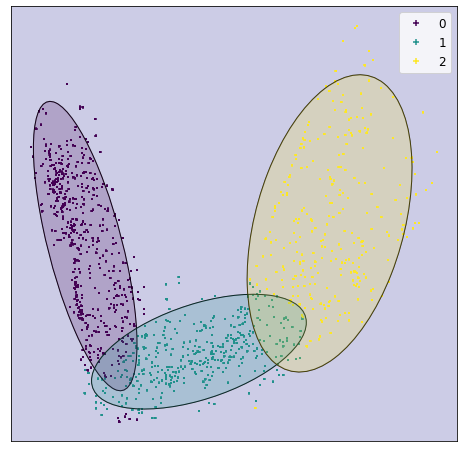

In [17]:
lab='gmm_clusters'
n_classes=3
# Plot the profiles, coloured by GMM class assignment
sc=plt.scatter(data_pca.isel(pca_comp=0), data_pca.isel(pca_comp=1), c=data_classes, alpha=1, s=5, cmap='viridis', marker='+')
leg=plt.legend(*sc.legend_elements(),fontsize=12)

cmap = get_cmap('viridis')
means = gmm.means_
inds = np.argsort(means[:, 0])
means = means[inds, :]

# Get ellipse parameters from GMM covariances
(As, Bs, Ts) = get_abt(gmm.covariances_[inds, :, :])

# Plot an ellipse for each class at equal probabilities
for (i, (a, b, t)) in enumerate(zip(As, Bs, Ts)):
    rgba = list(cmap(i / (n_classes - 1)))
    rgba[-1] = 0.2
    plt.gca().add_artist(Ellipse(means[i, :], 4*np.sqrt(a), 4*np.sqrt(b), -t, fill=False))
    plt.gca().add_artist(Ellipse(means[i, :], 4*np.sqrt(a), 4*np.sqrt(b), -t, fill=True, color=rgba))
plt.gca().set_facecolor((0.8, 0.8, 0.9))

plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.gcf().set_size_inches(8, 8)

plt.savefig('figures/{}_{}.pdf'.format(lab,n_classes), bbox_inches='tight')
plt.show()

In [26]:
avg_prof = clu.avg_profiles(data, data_classes, n_classes)

In [35]:
avg_prof[0]['mean'].size

50

In [31]:
levs= np.load('data/levs.npy', allow_pickle=True)

In [36]:
len(levs)

50

Text(0.5, 1.02, '3 Classes: UK-ESM')

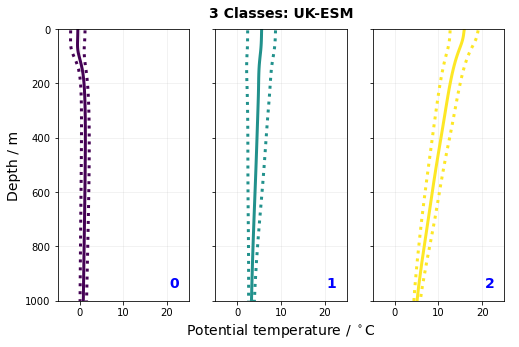

In [45]:
cmap = plt.get_cmap('viridis', n_classes)
figure, axes = plt.subplots(1, n_classes, sharey=True,figsize=(8, 5))

for (i, ax) in enumerate(axes):
    if i == 0:
        ax.set_ylabel('Depth / m')

    ax.text(0.85,0.05,str(i),fontweight='bold',fontsize=14,color='b',transform=ax.transAxes)
            
    ax.plot(avg_prof[i]['mean'],levs, color=cmap(i), linestyle='solid', linewidth=3)
    ax.plot(avg_prof[i]['mean']+avg_prof[i]['std'],levs, color=cmap(i), linestyle=':', linewidth=3)
    ax.plot(avg_prof[i]['mean']-avg_prof[i]['std'],levs, color=cmap(i), linestyle=':', linewidth=3)
    
    ax.set_ylim([1000,0])
    ax.set_xlim(-5,25)
    ax.grid(alpha=0.2)
    if i==0:
        ax.set_ylabel('Depth / m',fontsize=14)
  
figure.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Potential temperature / ${}^\circ$C',fontsize=14)    

plt.title('{} Classes: UK-ESM'.format(n_classes),fontsize=14,fontweight='bold',y=1.02)

In [16]:
data_classes

<xarray.DataArray 'thetao' (time: 12, n: 22194)>
dask.array<transpose, shape=(12, 22194), dtype=int64, chunksize=(12, 1024), chunktype=numpy.ndarray>
Coordinates:
    lat      (n) float32 dask.array<chunksize=(1024,), meta=np.ndarray>
    lon      (n) float32 dask.array<chunksize=(1024,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2000-12-01
  * n        (n) MultiIndex
  - i        (n) int64 0 0 0 0 0 0 0 0 0 ... 359 359 359 359 359 359 359 359 359
  - j        (n) int64 81 82 83 84 85 86 87 88 ... 132 133 134 135 136 137 138

In [19]:
# Load fronts
fronts=['saf','pf','saccf','sbdy']
front_data={}
for front in fronts:
    front_data[front]=np.loadtxt('data/fronts/{}_kim.txt'.format(front))

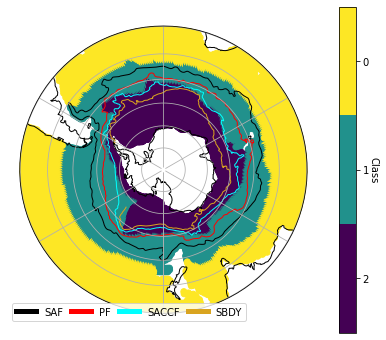

In [28]:
import cartopy.crs as ccrs
import matplotlib.path as mpath
proj = ccrs.SouthPolarStereo()
front_colors=['black','red','cyan',(218/256,165/256,32/256)]
#colormap = plt.get_cmap('RdBu_r', n_classes)
colormap = get_cmap('viridis',n_classes)

fig=plt.figure(figsize=(7,6))

ax = plt.subplot(1,1,1,projection=proj)
    
CS=ax.scatter(data_classes.lon,data_classes.lat,c=clu.modal_classes(data_classes,dims=['time']),cmap=colormap,transform=ccrs.PlateCarree())
for indf,front in enumerate(fronts):
    ax.plot(front_data[front][:,0], front_data[front][:,1], lw = 1, ls='-', label=front.upper(),color=front_colors[indf],transform=ccrs.PlateCarree())

#leg = ax.legend(bbox_to_anchor=( 1.25,1.2), ncol=4, \
#                         columnspacing = 0.8)
leg = ax.legend(ncol=4, columnspacing = 0.8)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

# compute a circle in axes coordinates, 
# which we can use as a boundary for the map.
theta = np.linspace(0, 2*np.pi, 100)
center = [0.5, 0.5]
radius = 0.46   # 0.46 corresponds to roughly 30S Latitude
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

# Add features
ax.gridlines()
#ax.add_feature(cfeature.LAND)
ax.coastlines()

colorbar = plt.colorbar(CS)
dclass=(n_classes-1)/n_classes
cticks = np.arange(dclass/2, n_classes-1, dclass)
clabels=np.arange(n_classes-1,-1,-1)
colorbar.set_ticks(cticks)
colorbar.set_ticklabels(clabels)
colorbar.set_label('Class', rotation=270, labelpad=10)
#plt.savefig('figures/8class_lonlat_ensmean.png')